## Обучение многослойного перцептрона

Сам перцептрон

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from framework.nn import MLP

In [4]:
model = MLP(3, [4, 4, 1])
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)]
Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)]
Layer of [LinearNeuron(4)]]
number of parameters 41


Набор данных

In [5]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [6]:
history = []
for k in range(2_000):

    # forward
    out = [model(x) for x in xs]

    # calculate loss (mean square error)
    acc = 0
    total_loss = 0
    for y_pred, y_true in zip(out, ys):
        total_loss += (y_pred - y_true) ** 2
        acc += round(y_pred.data) == y_true
    total_loss = total_loss / len(ys)
    acc = acc / len(ys)
    history.append(total_loss.data)
    
    # backward (zero_grad + backward)
    model.zero_grad()
    total_loss.backward()
    
    # update
    learning_rate = 0.001
    for p in model.parameters():
        p.data = p.data - learning_rate * p.grad
    
    
    if (k + 1) % 400 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1889.0, accuracy 0.0%
step 400 loss 0.8491560611586679, accuracy 0.0%
step 800 loss 0.5598632663471556, accuracy 25.0%
step 1200 loss 0.13218400504446332, accuracy 75.0%
step 1600 loss 0.05611870318542738, accuracy 100.0%


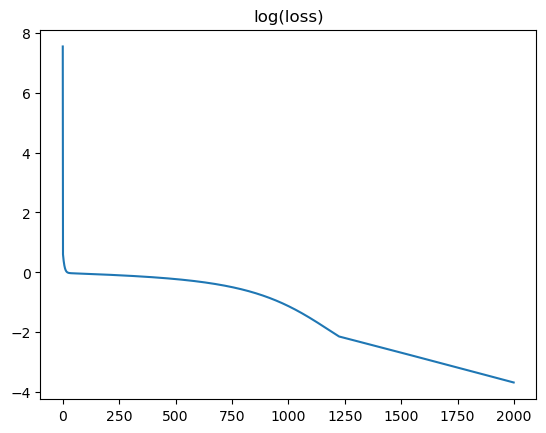

In [11]:
plt.title("log(loss)")
plt.plot(range(len(history)), [np.log(h) for h in history])
plt.show()

# Домашнее задание

In [1]:
def show_tensor_params(*tensors):
    for x in tensors:
        print('---')
        print(f"data - {x.data}")
        print(f"grad - {x.grad}")
        print(f"grad_fn - {x.grad_fn}")
        print(f"req_grad - {x.requires_grad}")
        print(f"is_leaf - {x.is_leaf}")

**Домашнее задание 1.** Доделать практику. Оформить код в три отдельных модуля `autograd`, `nn`, `train`

**Домашнее задание 2 (Опционально).** Создать свою функцию softmax, наследуемую от `torch.autograd.Function` и имплементировать forward и backward проход. Сравнить со стандартной функцией в Pytorch. 
[Создание функций](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) [Софтмакс](https://congyuzhou.medium.com/softmax-3408fb42d55a)

In [2]:
import torch
from framework.autograd import Softmax
from torch import softmax

In [4]:
# Объявляем 2 одинаковых тензора
input = torch.tensor([1.0, 4.0, -3.0, 2.0], requires_grad=True)
input_torch = torch.tensor([1.0, 4.0, -3.0, 2.0], requires_grad=True)

# Сравниваем функции
output = Softmax.apply(input)
output_torch = softmax(input_torch, 0)
print("Is my softmax the same as torch's?", torch.allclose(output, output_torch))

res = torch.sum(output**2)
res.backward()

res_torch = torch.sum(output_torch**2)
res_torch.backward()

show_tensor_params(input)
show_tensor_params(input_torch)

Is my softmax the same as torch's? True
---
data - tensor([ 1.,  4., -3.,  2.])
grad - tensor([3.3763e-03, 2.2301e-01, 1.1814e-06, 2.3070e-02])
grad_fn - None
req_grad - True
is_leaf - True
---
data - tensor([ 1.,  4., -3.,  2.])
grad - tensor([-0.0574,  0.1981, -0.0011, -0.1396])
grad_fn - None
req_grad - True
is_leaf - True


In [15]:
output * (1 - output) * 2

tensor([0.0804, 0.2645, 0.0015, 0.2022], grad_fn=<MulBackward0>)

In [8]:
print(output.grad)
print(output_torch.grad)

None
None


C:\Users\Professional\anaconda3\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


**Домашнее задание 3 (Опционально).** Добавить функцию софтмакс в собственну библиотеку автоматического дифференцирования. Сравнить с пунктом 2

In [3]:
from framework.nn import autoSoftmax
from framework.autograd import Value
import torch
from framework.autograd import Softmax
from torch import softmax

input = torch.tensor([1.0, 4.0, -3.0, 2.0], requires_grad=True)
input_val = Value(input.clone().detach())
output = autoSoftmax(input_val)
output_torch = softmax(input, 0)
print(output)
print(output_torch)
print("IS my softmax the same as torch's?", torch.allclose(output.data, output_torch))

res = (output ** 2).sum(axes=0)
res.backward()
print(input_val.grad)

res_torch = (output_torch ** 2).sum()
res_torch.backward()
print(input.grad)

print("Are gradients are the same?", torch.allclose(input_val.grad.data, input.grad))

Value(data=tensor([4.1978e-02, 8.4315e-01, 7.6885e-04, 1.1411e-01]), grad=0)
tensor([4.1978e-02, 8.4315e-01, 7.6885e-04, 1.1411e-01],
       grad_fn=<SoftmaxBackward0>)
IS my softmax the same as torch's? True
tensor([-0.0574,  0.1981, -0.0011, -0.1396])
tensor([-0.0574,  0.1981, -0.0011, -0.1396])
Are gradients are the same? True


**Домашнее задание 4 (Опционально).** Добавить визуализацию обучения. Потом мы пройдем более подробно.

https://docs.wandb.ai/guides/integrations/pytorch

https://docs.wandb.ai/ref/python/watch  

https://docs.wandb.ai/guides/track/jupyter

In [ ]:
!pip install wandb

In [18]:
!wandb login

wandb: Currently logged in as: natifick. Use `wandb login --relogin` to force relogin


In [19]:
import wandb
run = wandb.init(project="polynom_learning_")

wandb: Currently logged in as: natifick. Use `wandb login --relogin` to force relogin


In [20]:
import matplotlib.pyplot as plt
import numpy as np

from framework.nn import MLP

model = MLP(3, [4, 4, 1])

In [21]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [26]:
for k in range(2_000):

    # forward
    out = [model(x) for x in xs]

    # calculate loss (mean square error)
    acc = 0
    total_loss = 0
    for y_pred, y_true in zip(out, ys):
        total_loss += (y_pred - y_true) ** 2
        acc += round(y_pred.data) == y_true
    total_loss = total_loss / len(ys)
    acc = acc / len(ys)
    wandb.log({'loss': total_loss.data,
               'accuracy': acc})
    
    # backward (zero_grad + backward)
    model.zero_grad()
    total_loss.backward()
    
    # update
    learning_rate = 0.001
    for p in model.parameters():
        p.data = p.data - learning_rate * p.grad
    
    if (k + 1) % 400 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 399 loss 0.8496043201932275, accuracy 0.0%
step 799 loss 0.5609290555307663, accuracy 25.0%
step 1199 loss 0.13283780088484257, accuracy 75.0%
step 1599 loss 0.05623034679774579, accuracy 100.0%
step 1999 loss 0.025279782125270427, accuracy 100.0%


In [27]:
run.finish()

accuracy,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆████████████████
loss,█▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,1.0
loss,0.02528


## Картинка

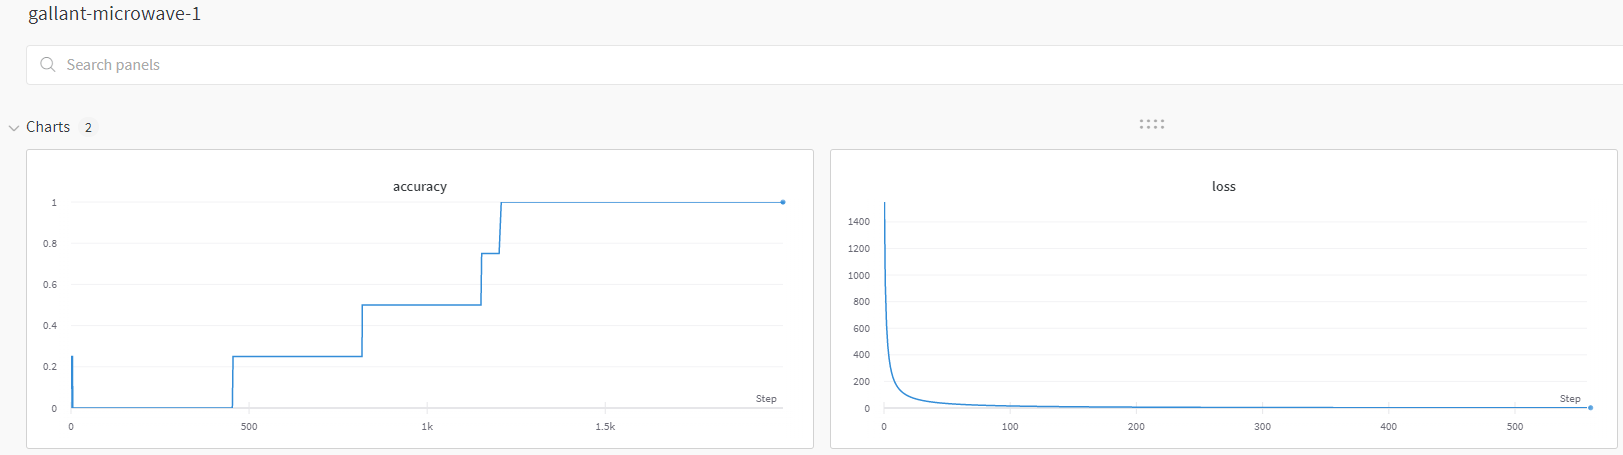